<a href="https://www.kaggle.com/code/uncomment/fireducks-benchmark?scriptVersionId=195471716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
# !pip install fireducks polars plotly

In [10]:
import os
import time

# disabling lazy-execution mode of FireDucks
os.environ["FIREDUCKS_FLAGS"] ="--benchmark-mode"

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [11]:
results = {}
# path = "/kaggle/input/zvuk-dataset/zvuk-interactions.parquet"
path = "./data/zvuk-interactions.parquet"

def append(lib, *args):
    results[lib] = list(args)
    
    
def bench_polars():
    stime = time.time()
    df = pl.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.drop_nulls()
    dropna_t = time.time() - stime

    stime = time.time()
    fdf = df.filter((pl.col('play_duration') > 0) & (pl.col('play_duration') < 1000))
    filter_t = time.time() - stime
    
    stime = time.time()
    desc = df['play_duration'].describe()
    desc_t = time.time() - stime

    stime = time.time()
    sdf = df['user_id'].value_counts(sort=True)
    vcount_t = time.time() - stime    
     
    stime = time.time()
    hour_wise_mean = (
        df.with_columns(
            pl.col("datetime").dt.hour().alias("hour"),
        )
        .group_by("hour").agg(pl.col("play_duration").mean())
    )
    group_agg_t = time.time() - stime
    
    # query combining groupby and sort to find top-10 users based on play_duration
    stime = time.time()
    user_wise_mean = (
        df.group_by("user_id").agg(pl.col("play_duration").mean()).sort("play_duration", descending=True).head(10)
    )
    top10_user_t = time.time() - stime

    append("polars", load_t, dropna_t, filter_t, desc_t, vcount_t, group_agg_t, top10_user_t)
    print(
        f"[polars] load-time: {load_t} sec; dropna-time: {dropna_t} sec; "
        f"filter-time: {filter_t} sec; describe-time: {desc_t} sec; "
        f"value-count-time: {vcount_t} sec; "
        f"group-agg-time: {group_agg_t} sec; top10-user-time: {top10_user_t} sec"
    )


def bench_others(pd):
    stime = time.time()
    df = pd.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    load_t = time.time() - stime

    stime = time.time()
    no_na = df.dropna()
    dropna_t = time.time() - stime
    
    stime = time.time()
    fdf = df[(df['play_duration'] > 0) & (df['play_duration'] < 1000)]
    filter_t = time.time() - stime

    stime = time.time()
    desc = df['play_duration'].describe()
    desc_t = time.time() - stime 
    
    stime = time.time()
    sdf = df['user_id'].value_counts(sort=True)
    vcount_t = time.time() - stime

    stime = time.time()
    hour_wise_mean = (
        df.assign(hour=lambda df: df["datetime"].dt.hour).groupby("hour")["play_duration"].mean()
    )
    group_agg_t = time.time() - stime
    
    # query combining groupby and sort to find top-10 users based on play_duration
    stime = time.time()
    user_wise_mean = (
        df.groupby("user_id")["play_duration"].mean().sort_values(ascending=False).head(10)
    )
    top10_user_t = time.time() - stime
    
    lib = pd.__name__
    append(lib, load_t, dropna_t, filter_t, desc_t, vcount_t, group_agg_t, top10_user_t)
    print(
        f"[{lib}] load-time: {load_t} sec; dropna-time: {dropna_t} sec; "
        f"filter-time: {filter_t} sec; desctibe-time: {desc_t} sec; "
        f"value-counts-time: {vcount_t} sec; "
        f"group-agg-time: {group_agg_t} sec; top10-user-time: {top10_user_t} sec"
    )
    



In [12]:
import pandas as pd
import fireducks.pandas as fd
import polars as pl

import platform, psutil
import fireducks

print("="*30, "Evaluation Environment Information", "="*30)
print(f'platform: {platform.system()}')
print(f'architecture: {platform.machine()}')
print(f'processor: {platform.processor()}')
print(f'cpu: {psutil.cpu_count()}')
print(f'ram: {str(round(psutil.virtual_memory().total / (1024 ** 3)))} GB')
print(f'pandas-version: {pd.__version__}')
print(f'fireducks-version: {fireducks.__version__}')
print(f'polars-version: {pl.__version__}')


============================== Evaluation Environment Information ==============================
platform: Linux
architecture: x86_64
processor: x86_64
cpu: 4
ram: 31 GB
pandas-version: 2.2.2
fireducks-version: 0.12.6
polars-version: 1.7.1


In [13]:
import gc

# pandas and FireDucks share same APIs, hence same benchmark code can be used for both
for mod in [pd, fd]: 
    bench_others(mod)
    gc.collect()
    
# polars APIs are different, hence need to separate it out    
bench_polars()
gc.collect(); 

results = pd.DataFrame.from_dict(results)
results.index = ["load-time", "dropna-time", "filter-time", "describe-time", "value-count-time", "groupby-agg-time", "top10-user-time"]
results = round(results, 4)
results.to_csv('./results/benchmark.csv')

[pandas] load-time: 5.971887588500977 sec; dropna-time: 2.296063184738159 sec; filter-time: 9.2858407497406 sec; desctibe-time: 7.641731023788452 sec; value-counts-time: 1.979933500289917 sec; group-agg-time: 20.974783182144165 sec; top10-user-time: 6.447349309921265 sec
[fireducks.pandas] load-time: 3.6720211505889893 sec; dropna-time: 0.7964656352996826 sec; filter-time: 1.9566595554351807 sec; desctibe-time: 6.057678699493408 sec; value-counts-time: 2.3548977375030518 sec; group-agg-time: 1.6684279441833496 sec; top10-user-time: 1.7466599941253662 sec
[polars] load-time: 4.1645824909210205 sec; dropna-time: 0.016197919845581055 sec; filter-time: 1.5072035789489746 sec; describe-time: 2.587137222290039 sec; value-count-time: 4.505621433258057 sec; group-agg-time: 3.622037172317505 sec; top10-user-time: 3.8880808353424072 sec


,pandas,fireducks.pandas,polars
load-time,5.9719,3.6720,4.1646
dropna-time,2.2961,0.7965,0.0162
filter-time,9.2858,1.9567,1.5072
describe-time,7.6417,6.0577,2.5871
value-count-time,1.9799,2.3549,4.5056
groupby-agg-time,20.9748,1.6684,3.6220
top10-user-time,6.4473,1.7467,3.8881


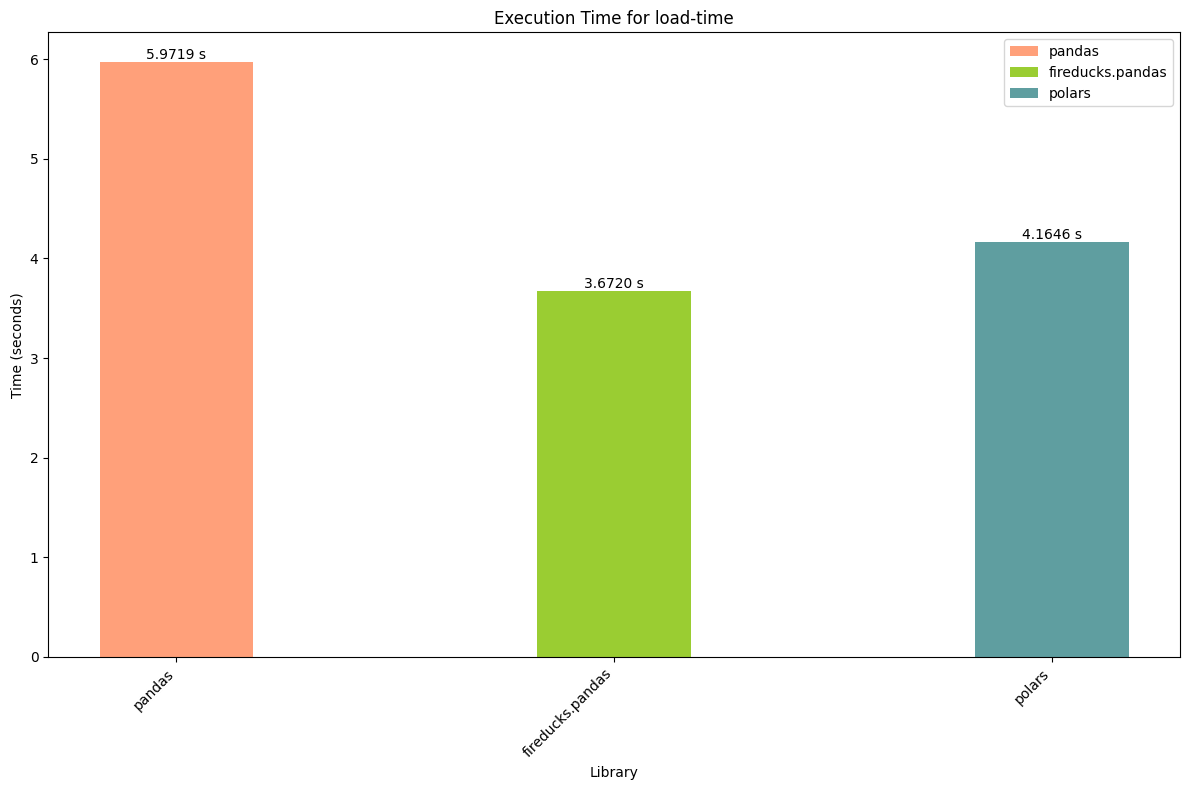

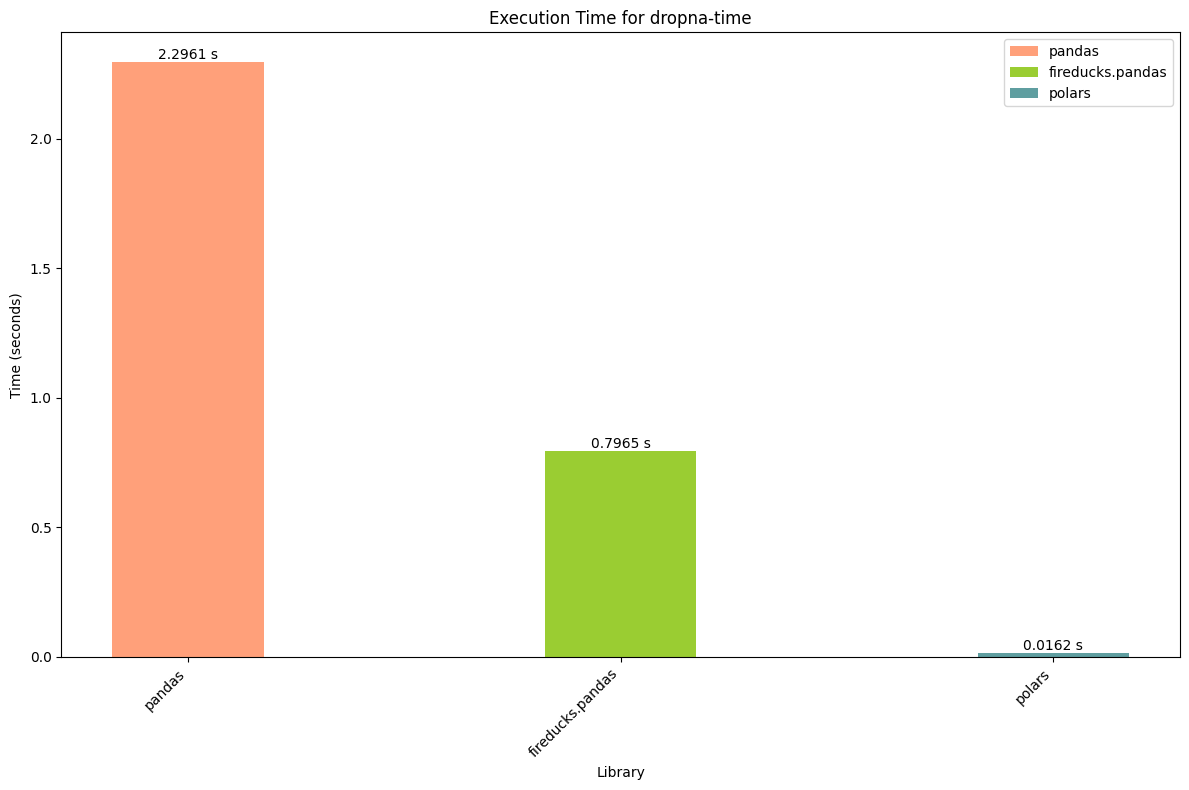

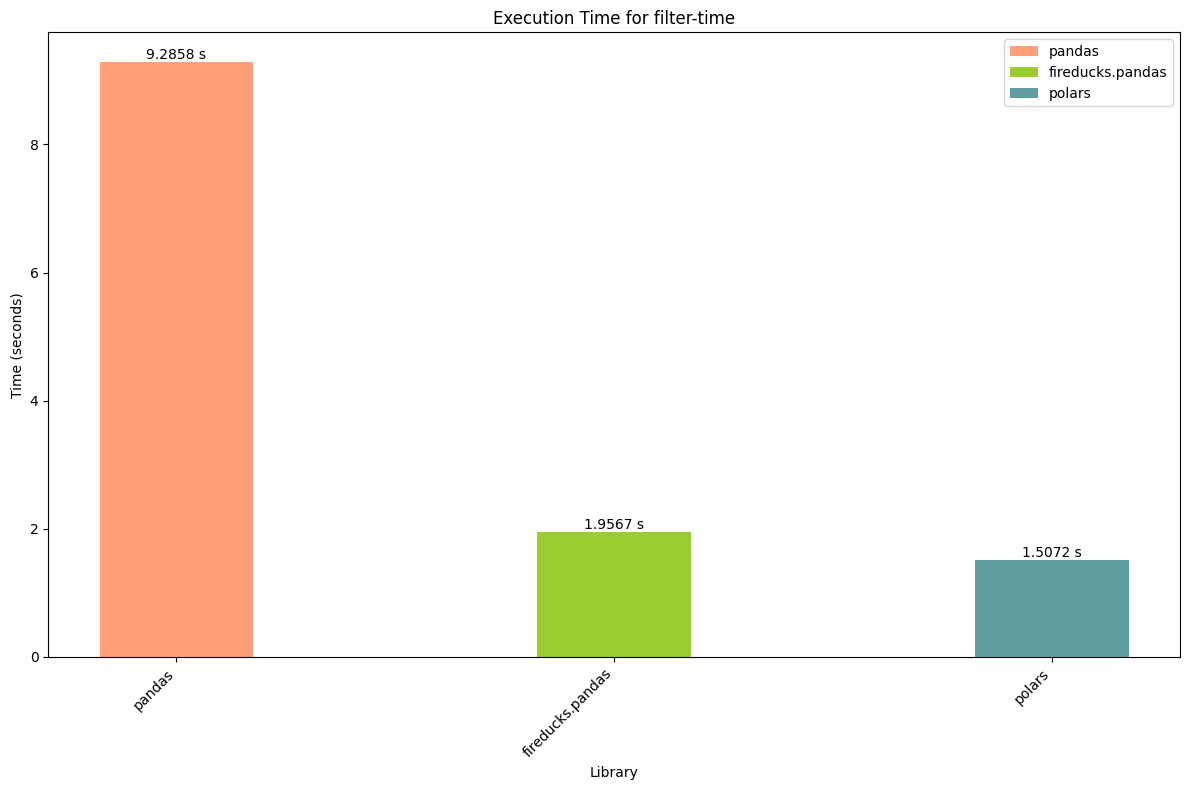

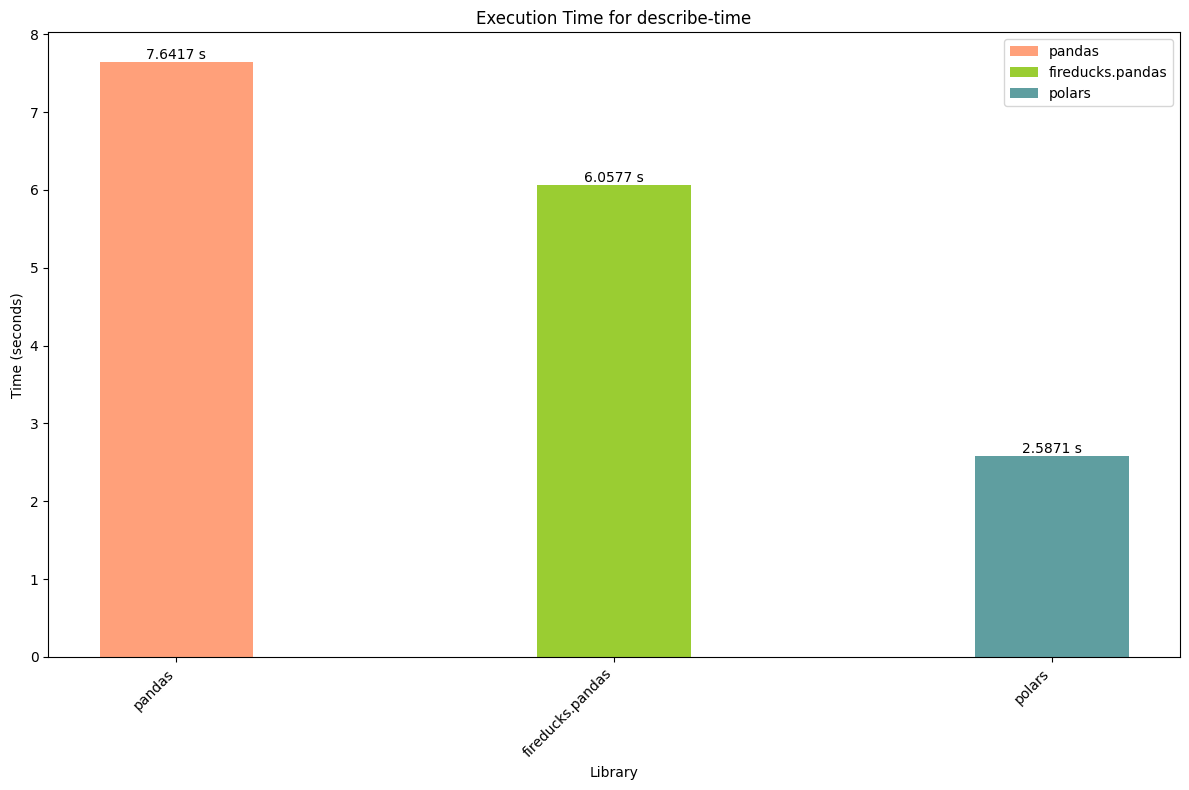

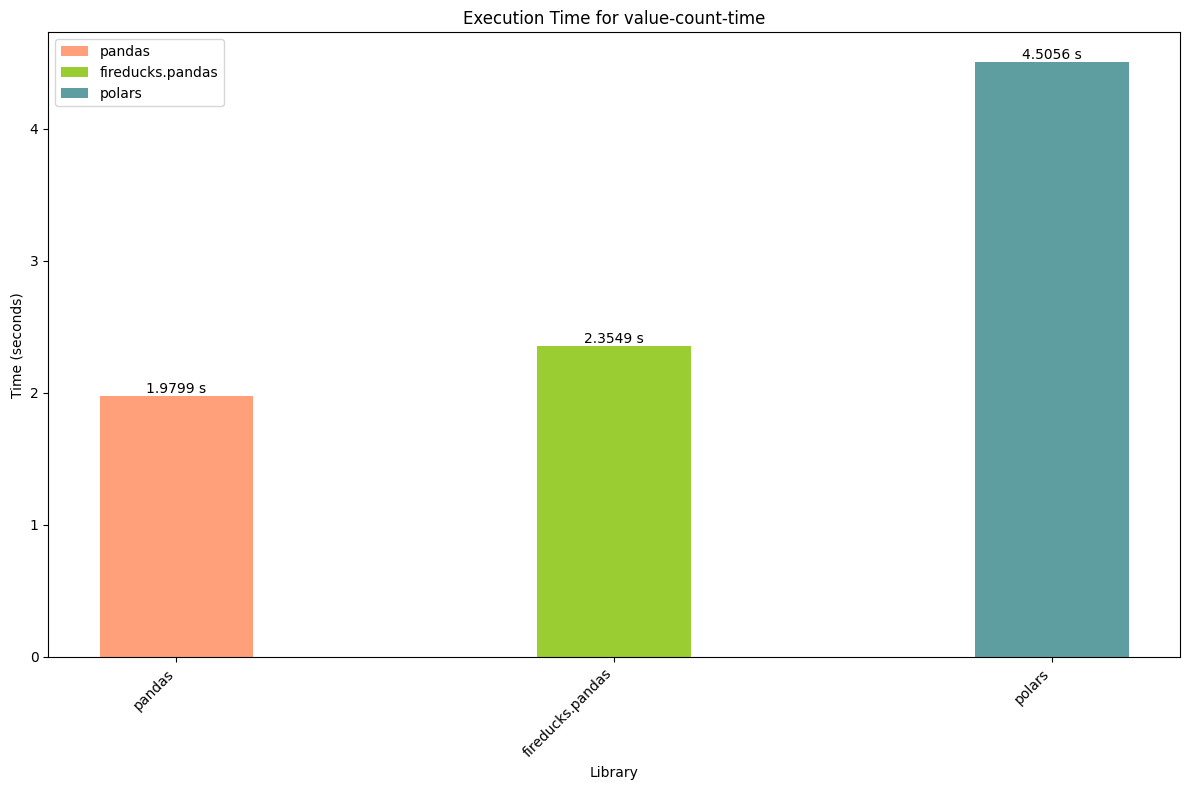

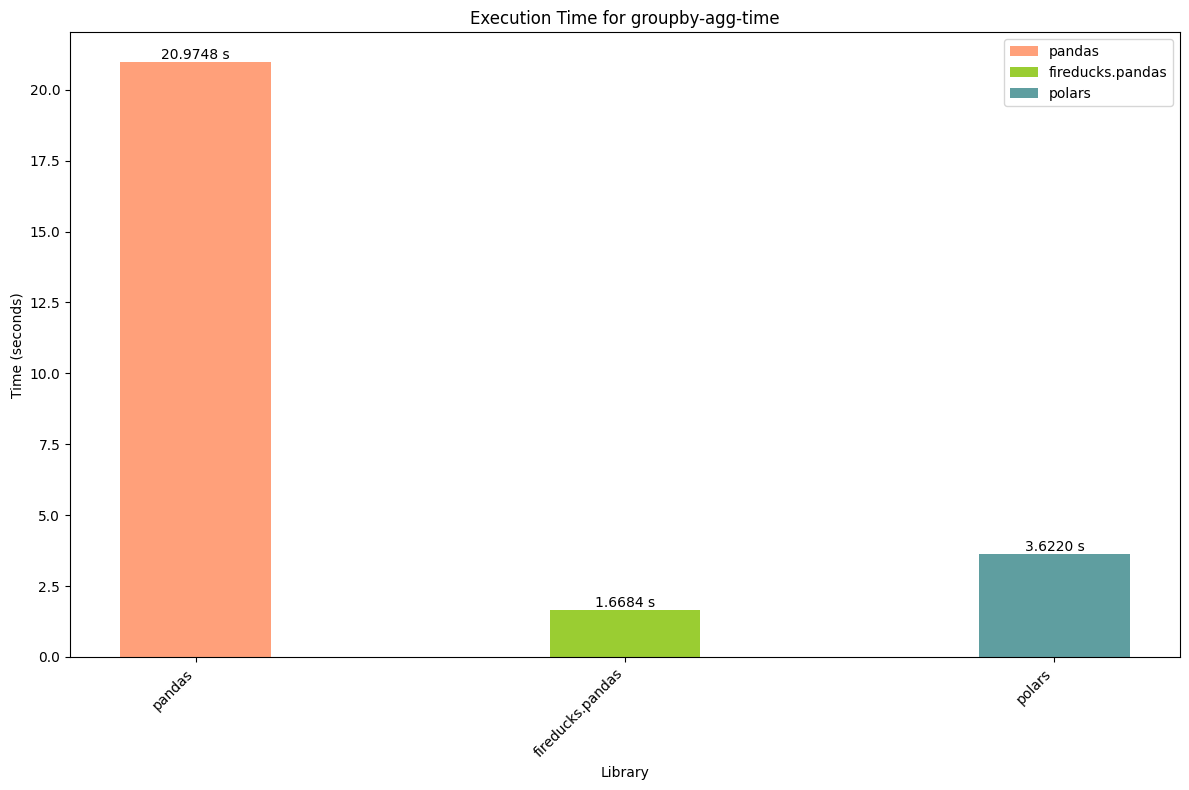

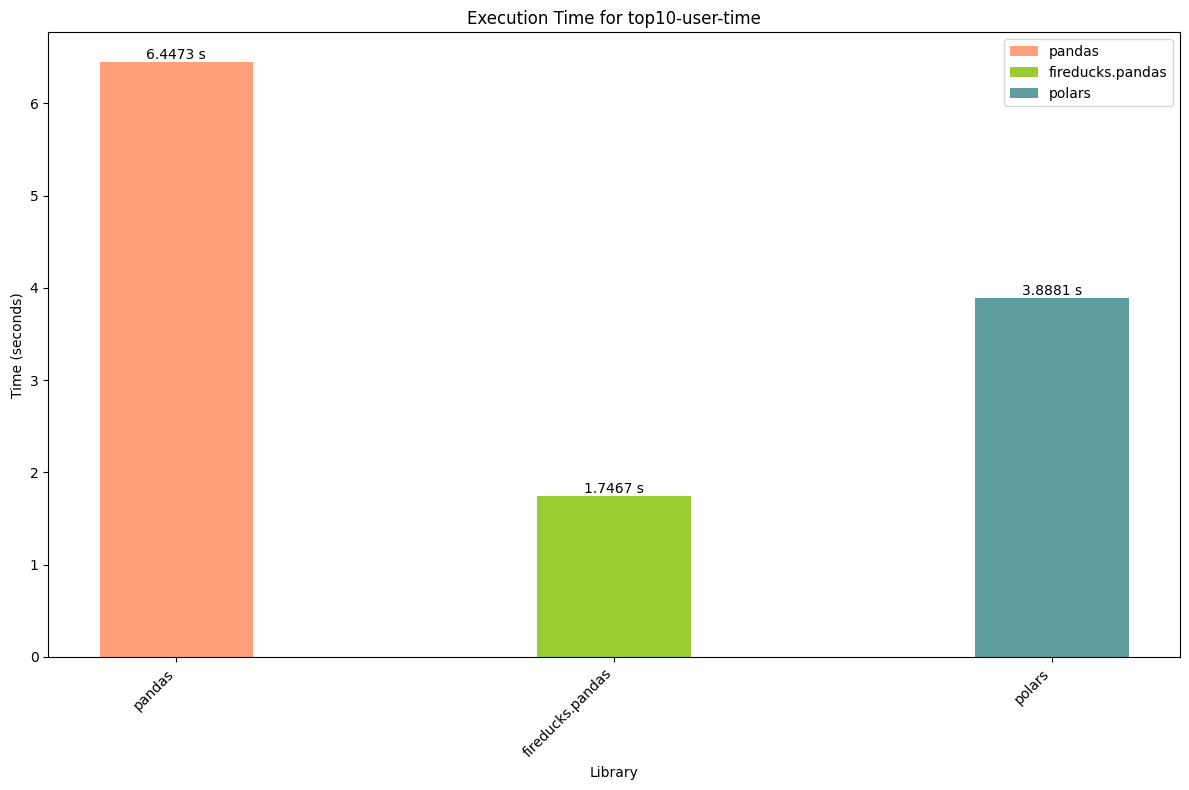

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create the results folder if it doesn't exist
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Assuming `results` is your DataFrame
operations = results.index.tolist()
libraries = results.columns.tolist()
colors = ["lightsalmon", "yellowgreen", "cadetblue"]

# Combined plot for all operations
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
index = np.arange(len(operations))

for i, lib in enumerate(libraries):
    times = results[lib].tolist()
    ax.bar(index + i * bar_width, times, bar_width, label=lib, color=colors[i])

ax.set_xlabel('Operation')
ax.set_ylabel('Time (seconds)')
ax.set_title('Execution Time by Operation and Library')
ax.set_xticks(index + bar_width * (len(libraries) - 1) / 2)
ax.set_xticklabels(operations, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'execution_times_combined.png'))
plt.close()  # Close the figure to free up memory

# Separate plots for each operation
for op in operations:
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    index = np.arange(len(libraries))
    times = results.loc[op].tolist()
    
    for i, lib in enumerate(libraries):
        time = times[i]
        ax.bar(index[i], time, bar_width, label=lib, color=colors[i])
        ax.text(index[i], time, f"{time:.4f} s", ha='center', va='bottom')
    
    ax.set_xlabel('Library')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Execution Time for {op}')
    ax.set_xticks(index)
    ax.set_xticklabels(libraries, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(results_folder, f'{op}_execution_times.png'))
    plt.close()  # Close the figure to free up memory

Top 10 users based on play_duration (FireDucks):
user_id
9043177    791.5
3604129    755.0
5509694    755.0
2542096    655.5
1610655    651.0
2742185    649.0
6282320    647.0
8754738    641.0
5768008    635.0
7602854    614.0
Name: play_duration, dtype: float64


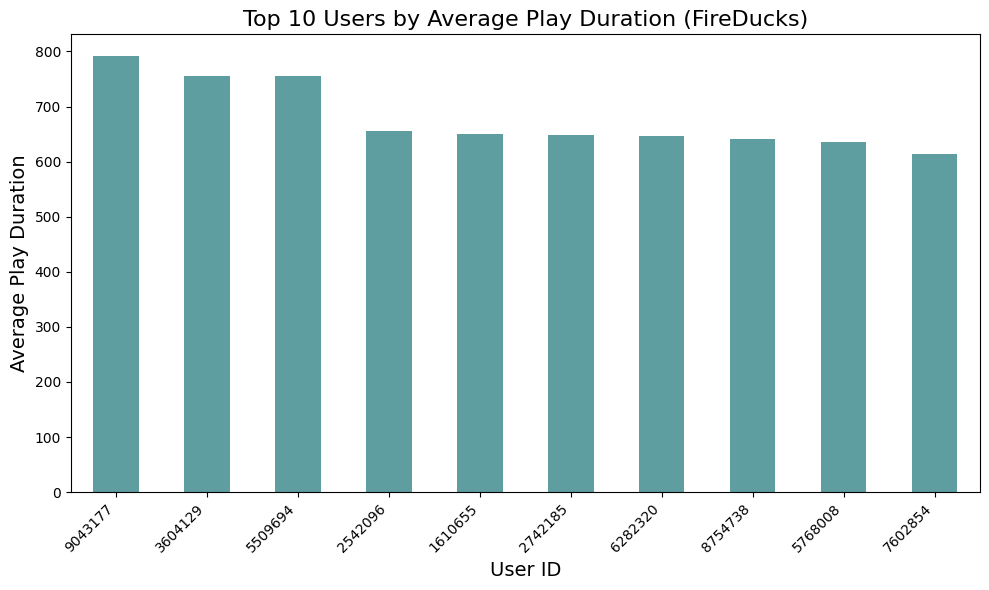

In [26]:
import pandas as pd
import fireducks.pandas as fd
import polars as pl
import matplotlib.pyplot as plt
import gc
import time
import os

# Create the results folder if it doesn't exist
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

def get_top10_users_fireducks():
    path = "./data/zvuk-interactions.parquet"
    
    stime = time.time()
    df = fd.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    
    # Ensure data filtering is consistent
    fdf = df[(df['play_duration'] > 0) & (df['play_duration'] < 1000)]
    
    # Get top 10 users based on play_duration
    top10_users = (
        fdf.groupby("user_id")["play_duration"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    
    print(f"Top 10 users based on play_duration (FireDucks):\n{top10_users}")
    return top10_users

def get_top10_users_pandas():
    path = "/kaggle/input/zvuk-dataset/zvuk-interactions.parquet"
    
    stime = time.time()
    df = pd.read_parquet(path, columns=["datetime", "play_duration", "user_id"])
    
    # Ensure data filtering is consistent
    pdf = df[(df['play_duration'] > 0) & (df['play_duration'] < 1000)]
    
    # Get top 10 users based on play_duration
    top10_users = (
        pdf.groupby("user_id")["play_duration"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    
    print(f"Top 10 users based on play_duration (Pandas):\n{top10_users}")
    return top10_users

def plot_top10_users(top10_users, library_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    top10_users.plot(kind='bar', color='cadetblue', ax=ax)
    
    ax.set_title(f'Top 10 Users by Average Play Duration ({library_name})', fontsize=16)
    ax.set_xlabel('User ID', fontsize=14)
    ax.set_ylabel('Average Play Duration', fontsize=14)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(results_folder, f'top10_users_{library_name.lower()}.png'))
    
    plt.show()

# Execute and get the top 10 users for FireDucks
top10_users_fireducks = get_top10_users_fireducks()

# # Execute and get the top 10 users for Pandas
# top10_users_pandas = get_top10_users_pandas()

# Plotting the graph for top 10 users (FireDucks)
plot_top10_users(top10_users_fireducks, "FireDucks")

# # Plotting the graph for top 10 users (Pandas)
# plot_top10_users(top10_users_pandas, "Pandas")